In [20]:
# pandas - pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool.
# See more at: https://pandas.pydata.org/docs/
import pandas as pd

# NumPy - The fundamental package for scientific computing.
# See more at: https://numpy.org/doc/stable/reference/index.html
import numpy as np

# scikit-learn - Simple and efficient tools for predictive data analysis
# See more at: https://scikit-learn.org/stable/modules/classes.html

# - Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# - Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

# - Naive Bayes classifier for multinomial models
from sklearn.naive_bayes import MultinomialNB

# - Naive Bayes classifier for multinomial models
from sklearn.naive_bayes import GaussianNB

# - Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# - A decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# - Accuracy classification score
from sklearn.metrics import accuracy_score

# - Compute confusion matrix to evaluate the accuracy of a classification
from sklearn.metrics import confusion_matrix

# - Confusion Matrix visualization
from sklearn.metrics import ConfusionMatrixDisplay

# matplotlib - A comprehensive library for creating static, animated, and interactive visualizations
# See more at: https://matplotlib.org/stable/contents.html

# - pyplot is mainly intended for interactive plots and simple cases of programmatic plot generation
import matplotlib.pyplot as plt

# - Colormap objects based on lookup tables using linear segments
from matplotlib.colors import LinearSegmentedColormap

In [19]:
# Dataset file path
path = "fake_job_postings.csv"

# Load dataset into a DataFrame and fill missing values
df = pd.read_csv(path, index_col="job_id").fillna("Missing")

# Isolate target data
target = df["fraudulent"]

In [21]:
# Get categorical dummies from column
def get_most_fraudulent_dummies(column):
    # Cross analisys between column and target
    cross = pd.crosstab(column, target)

    # Filter the 20 larger positive occurrences
    filtered = cross[1].sort_values(ascending=False).iloc[0:20]

    # Get categories
    categories = filtered.index

    # Create a new DataFrame
    dummies = pd.DataFrame(index=column.index)

    # Create a new column for each categorie
    for categorie in categories:
        # New column name
        name = f"{column.name}-{categorie}"

        # Get line dummie value
        categorie_value = column == categorie

        # Convert value from boolean to int
        categorie_dummies = categorie_value.apply(int)

        # Append new column
        dummies[name] = categorie_dummies

    return dummies

# Join categorigal feature dummies into the DataFrame
df = df.join(get_most_fraudulent_dummies(df["department"]))
df = df.join(get_most_fraudulent_dummies(df["employment_type"]))
df = df.join(get_most_fraudulent_dummies(df["required_experience"]))
df = df.join(get_most_fraudulent_dummies(df["required_education"]))
df = df.join(get_most_fraudulent_dummies(df["industry"]))
df = df.join(get_most_fraudulent_dummies(df["function"]))

In [22]:
# Merge text columns
df["company"] = df["title"]  + " " + df["company_profile"] + " " + df["description"] + " " + df["requirements"] + " " + df["benefits"]

# Drop remaining columns not relevant to the analysis
df = df.drop(axis = "columns", columns = ["title", "location", "salary_range", "company_profile", "description", "requirements", "benefits", "fraudulent", "department", "employment_type", "required_experience", "required_education", "industry", "function"])

In [23]:
df.head()

,telecommuting,has_company_logo,has_questions,department-Missing,department-Engineering,department-Clerical,department-Oil & Energy,department-Information Technology,department-Administrative,department-Customer Service,...,function-Marketing,function-Human Resources,function-Management,function-Advertising,function-Financial Analyst,function-Data Analyst,function-Consulting,function-Distribution,function-Design,company
job_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,"Marketing Intern We're Food52, and we've creat..."
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Customer Service - Cloud Video Production 90 S...
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Commissioning Machinery Assistant (CMA) Valor ...
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Account Executive - Washington DC Our passion ...
5,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bill Review Manager SpotSource Solutions LLC i...


In [26]:
class Balanced_dataset:
    def __init__(self, feature, target, **kwargs):
        self.feature = feature
        self.target = target

        # Split feature and target into train and test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(feature, target, **kwargs)

    # Return n splits of feature and target
    def get_balanced_split(self, feature, target):
        # Positive and negative occurrences 
        target_true = target[target == 1]
        target_false = target[target == 0]

        # Amount of occurrences
        size_true = len(target_true)
        size_false = len(target_false)

        # Splits target into N pieces based on the highest occurrence value so that all splits have a balanced amount.
        if size_true > size_false:
            target_split = np.array_split(target_true, np.floor(size_true / size_false))
            target_base = target_false
        else:
            target_split = np.array_split(target_false, np.floor(size_false / size_true))
            target_base = target_true

        target_full_split = [pd.concat([split, target_base]) for split in target_split]

        # Join each target of each split with its respective feature
        balanced_splits = [(feature.loc[split.index], split) for split in target_full_split]

        return balanced_splits

    # Get a list of splits of the feature and target for training with all splits with balanced values
    def get_train(self):
        return self.get_balanced_split(self.X_train, self.y_train)

    # Get a list of the feature and target for testing
    def get_test(self):
        return self.X_test, self.y_test

In [27]:
dataset = Balanced_dataset(df, target, train_size=70/100)

In [32]:
# Convert all columns to string type in the main DataFrame
df.columns = df.columns.astype(str)

class Split_train_model:
    def __init__(self, dataset, classifier, vectorizer=None, vectorize_col=None):
        self.dataset = dataset
        self.classifier = classifier
        self.vectorizer = vectorizer
        self.vectorize_col = vectorize_col

        # Starts model training automatically
        self.train()

    def train(self):
        # Buffers a model and a vector for each training split
        self.models = []
        self.vectors = []

        for feature, target in self.dataset.get_train():
            vector = None
            if self.vectorizer:
                # Reset the feature indexes, isolate the vectorisable feature...
                feature.reset_index(inplace=True, drop=True)
                vectorize_Series = feature[self.vectorize_col].astype(str)
                del feature[self.vectorize_col]

                # ... then create a vector and fit the vectorisable feature on it, ...
                vector = self.vectorizer()
                vectorize_transform = vector.fit_transform(vectorize_Series).toarray()

                # ... put it on a new DataFrame and then join into the feature
                vectorize_dataframe = pd.DataFrame(vectorize_transform, index=feature.index)
                vectorize_dataframe.columns = vectorize_dataframe.columns.astype(str)
                feature = feature.join(vectorize_dataframe)

            # Create a classifier and train it by fitting the feature and target
            model = self.classifier().fit(feature, target)

            # Buffers the model and the vector
            self.models.append(model)
            self.vectors.append(vector)

    # Get model accuracy score with test dataset
    def test(self):
        # Get the test dataset
        X, y = self.dataset.get_test()

        # Runs the model with the test dataset
        predict = self.predict(X)

        # Get prediction accuracy score
        score = accuracy_score(y, predict)

        # Get confusion matrix
        confusion = confusion_matrix(y, predict, normalize="all")

        return score, confusion

    def predict(self, feature):
        # Buffer the prediction results of each model split
        feature_predicts = []

        for i, model in enumerate(self.models):
            # Copy the feature to predict for the model split and reset index
            feature_copy = feature.copy().reset_index(drop=True)

            if self.vectorizer:
                # Isolate the vectorisable feature...
                vectorize_feature = feature_copy[self.vectorize_col].astype(str)
                del feature_copy[self.vectorize_col]

                # ... get the current model vector and transform the vectorisable feature with it...
                vector = self.vectors[i]
                feature_transform = vector.transform(vectorize_feature).toarray()

                # ... put it on a new DataFrame and join into the feature
                feature_dataframe = pd.DataFrame(feature_transform, index=feature_copy.index)
                feature_dataframe.columns = feature_dataframe.columns.astype(str)
                feature_copy = feature_copy.join(feature_dataframe)

            # Runs the current model with the transformed feature
            predicts = model.predict(feature_copy)

            # Append the predicted result of each feature item into a 2D matrix (item x prediction)
            for j, predict in enumerate(predicts):
                if j >= len(feature_predicts):
                    feature_predicts.append([])

                feature_predicts[j].append(predict)

        # Get the average prediction of each feature item
        result = [np.round(sum(predict) / len(predict)) for predict in feature_predicts]

        return result


In [33]:
colormap = {'red':   [[ 0,       1, 1],
                      [ 1, 238/255, 1]],
            'green': [[ 0,       1, 1],
                      [ 1,  68/255, 1]],
            'blue':  [[ 0,       1, 1],
                      [ 1,  68/255, 1]]}

insper_colormap = LinearSegmentedColormap('insper', segmentdata=colormap)

In [35]:
MultinomialNB_model = Split_train_model(dataset, classifier=MultinomialNB, vectorizer=lambda: CountVectorizer(stop_words="english"), vectorize_col="company")
MultinomialNB_accuracy, MultinomialNB_confusion = MultinomialNB_model.test()

C:\Users\akhia\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


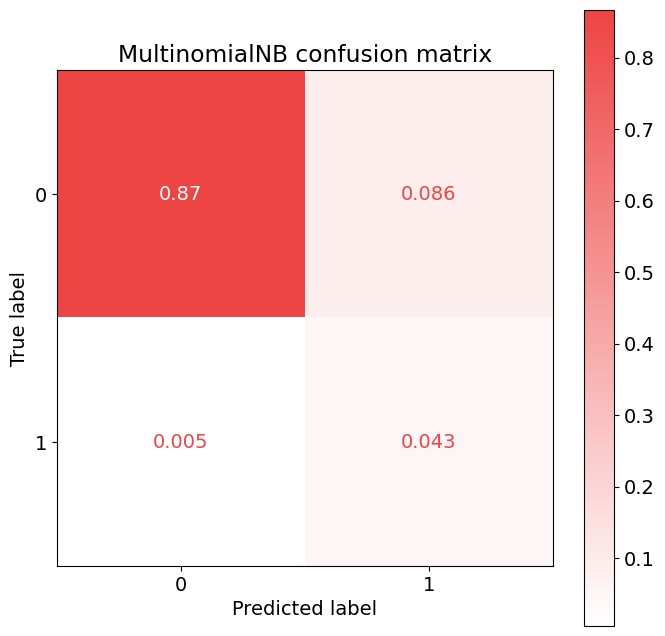

In [43]:
MultinomialNB_accuracy, MultinomialNB_confusion = MultinomialNB_model.test()

# Plot a heat map with the obtained values
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(title="MultinomialNB confusion matrix")
ConfusionMatrixDisplay(MultinomialNB_confusion).plot(ax=ax, cmap=insper_colormap)
plt.rcParams["font.size"] = "14"
plt.show()

In [44]:
GaussianNB_model = Split_train_model(dataset, classifier=GaussianNB, vectorizer=lambda: CountVectorizer(stop_words="english"), vectorize_col="company")
GaussianNB_accuracy, GaussianNB_confusion = GaussianNB_model.test()

C:\Users\akhia\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
GaussianNB_accuracy, GaussianNB_confusion = GaussianNB_model.test()

# Plot a heat map with the obtained values
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(title="GaussianNB confusion matrix")
ConfusionMatrixDisplay(GaussianNB_confusion).plot(ax=ax, cmap=insper_colormap)
plt.rcParams["font.size"] = "14"
plt.show()

In [51]:
DecisionTreeNB_model = Split_train_model(dataset, classifier=DecisionTreeClassifier, vectorizer=lambda: CountVectorizer(stop_words="english"), vectorize_col="company")
DecisionTreeNB_accuracy, DecisionTreeNB_confusion = DecisionTreeNB_model.test()

C:\Users\akhia\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


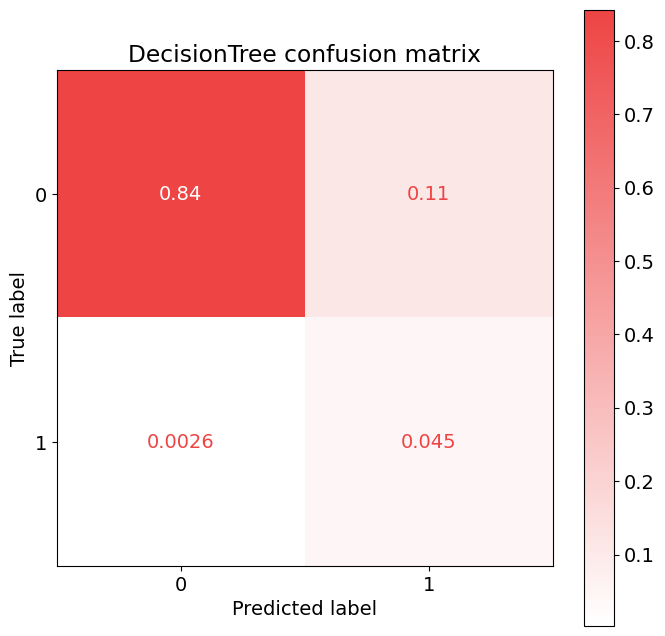

In [54]:
DecisionTree_accuracy, DecisionTree_confusion = DecisionTree_model.test()

# Plot a heat map with the obtained values
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(title="DecisionTree confusion matrix")
ConfusionMatrixDisplay(DecisionTree_confusion).plot(ax=ax, cmap=insper_colormap)
plt.rcParams["font.size"] = "14"
plt.show()

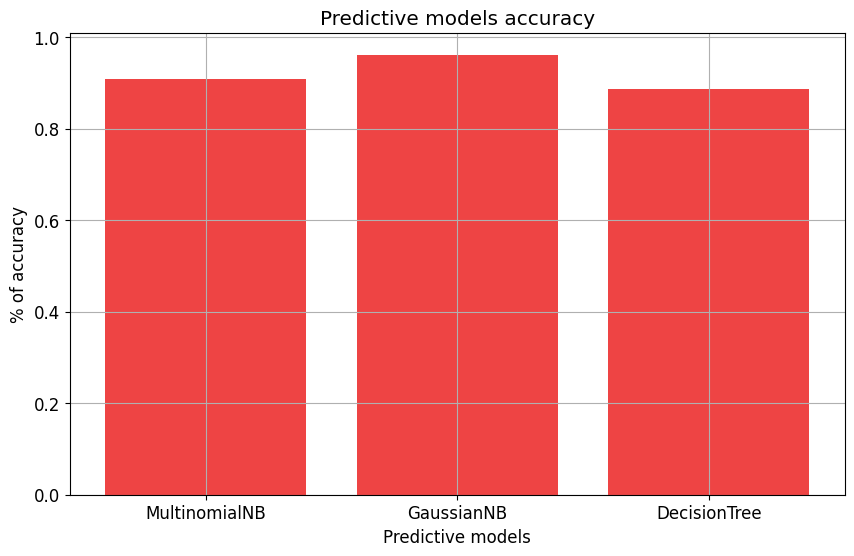

In [56]:
accuracies = [MultinomialNB_accuracy, GaussianNB_accuracy, DecisionTree_accuracy]
titles     = ["MultinomialNB", "GaussianNB", "DecisionTree"]

plt.figure(figsize=(10, 6))
plt.title("Predictive models accuracy")
plt.bar(titles, accuracies, color="#E44")
plt.xlabel("Predictive models")
plt.ylabel("% of accuracy")
plt.rcParams["font.size"] = "12"
plt.grid()
plt.show()